# Head Pose Estimation - Tilt

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Convolution2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tf.keras.optimizers.RMSprop
%matplotlib inline
import os
tf.__version__

Using TensorFlow backend.


'2.1.0'

In [2]:
#upload and unzip data file
import zipfile
with zipfile.ZipFile('./modified_data.zip', 'r') as zip_ref:
 zip_ref.extractall('./')

In [3]:
#Reading training data
train = pd.read_csv("./train_data.csv")
#understand shape of dataframe
train.head()

,filename,person_id,series,tilt,pan
0,face_790.jpg,5,1,-15,30
1,face_2445.jpg,5,1,0,-75
2,face_2266.jpg,5,2,-15,-60
3,face_2713.jpg,5,2,0,-90
4,face_2016.jpg,5,2,15,-75


## Understand Data and Preprocessing
Checking shape of training data and creating a plot to analyse Bias in data

In [4]:
train.shape

(2325, 5)

In [5]:
#grouping
shape_data_group= train.groupby(["tilt"])
shape_data_group_plot= shape_data_group.count()

,filename,person_id,series,pan
tilt,,,,
-90,25,25,25,25
-60,325,325,325,325
-30,325,325,325,325
-15,325,325,325,325
0,325,325,325,325
15,325,325,325,325
30,325,325,325,325
60,325,325,325,325
90,25,25,25,25


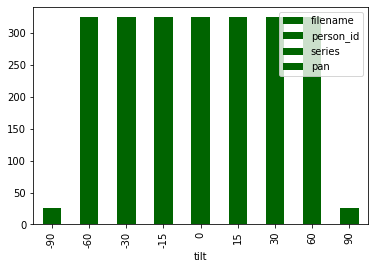

In [6]:
#plotting bar chart
shape_data_group_plot.plot(kind='bar',color=('darkgreen'))
shape_data_group.count()

In [7]:
train['tilt'] = train['tilt'].astype(str)

In [8]:
#Splitting Data into TRAIN, TEST AND VALIDATION
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(train,test_size = 0.2)
training_data, validation_data = train_test_split(train_data,test_size = 0.2)

# Generate two data frames for training and validation #
print('Train size: {}, Test size: {}'.format(training_data.shape[0], validation_data.shape[0] ) ) 
N_train_images = training_data.shape[0]
N_val_images = validation_data.shape[0]

Train size: 1488, Test size: 372


In [9]:
training_data.shape

(1488, 5)

In [10]:
validation_data.shape

(372, 5)

Inspecting the Data images in a random order

In [11]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('modified_data/*.jpg', recursive=True): #assuming gif
    headpose = filepath.split("/")[1]
    image_list.append((filepath, headpose))
headpose_data = pd.DataFrame(data=image_list, columns=['image_path', 'filename'])

In [12]:
headpose_data.head()

,image_path,filename
0,modified_data/face_182.jpg,face_182.jpg
1,modified_data/face_1317.jpg,face_1317.jpg
2,modified_data/face_2486.jpg,face_2486.jpg
3,modified_data/face_1.jpg,face_1.jpg
4,modified_data/face_1782.jpg,face_1782.jpg


In [13]:
import cv2
import os

for filepath in glob.glob('modified_data/*.jpg', recursive=True):
    
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(filepath), gray)

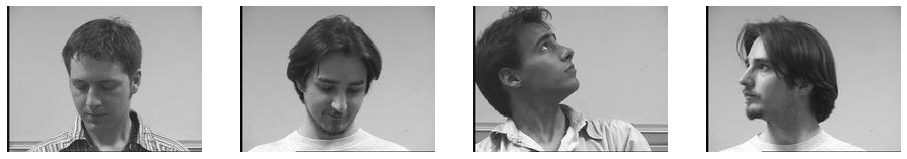

In [14]:
r_inx = np.random.choice(100, 4)
rand_data = headpose_data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

## Loading Function

we are using rmsprop and categorical_crossentropy snce there are more than two categories in the output variable.The dataset is complicated hence we will be loading them in batches, and batch size is chosen as 16. The loading function converts channels into 3-channel images. Data normalization is done to bring it in pixel [0-1] value

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_data,
    directory='./modified_data', 
    x_col="filename", 
    y_col="tilt", 
    target_size=(32, 32), 
    batch_size=batch_size, 
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory='./modified_data', 
    x_col="filename", 
    y_col="tilt", 
    target_size=(32, 32), 
    batch_size=batch_size, 
    class_mode='categorical')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./modified_data',
        x_col="filename",
        y_col="tilt",
        target_size=(32, 32),
        shuffle = False,
        batch_size=batch_size,
        class_mode='categorical')

Found 1488 validated image filenames belonging to 9 classes.
Found 372 validated image filenames belonging to 9 classes.
Found 465 validated image filenames belonging to 9 classes.


## Training model 

In [16]:
#function to train a model train the model
def train_model(model_, num_epoch=100, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

## Accuracy and Loss Function

In [17]:
def calculate_losses(model_, data_generator_, N_images, batch_size_): 
    loss_hold = []
    acc_hold = []
    batches = 0
    for x,y in data_generator_:
        loss,acc = model_.evaluate(x, y, verbose=0) 
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because 
            # the generator loops indefinitely
            break
        
    return np.mean(loss_hold), np.mean(acc_hold)

In [18]:
N_train_images = 1488
N_val_images = 372

## Model 1
We have 32x32 features and nine classes, so the input layer must have 1024 units, and the output layer must have 9 units. We only have to define the hidden layers. We're only going to have one hidden layer for this project, and we'll give it 64 neurons.

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy

# Input layer
input_ = Input(shape=(32, 32, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x)
h = Activation('sigmoid')(h)

# Output layer
out_ = Dense(9)(h)
out_ = Activation('softmax')(out_)

# Define model
model1 = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 32, 32, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 585       
_________________________________________________________________
activation_1 (Activation)    (None, 9)                 0     

In [20]:
#training the model
res = train_model(model1, num_epoch= 75, verbose=1)

Training epoch 0: Loss = 2.0375685691833496, Accuracy = 0.16532258689403534
Validation epoch 0: Loss = 1.9654303391774495, Accuracy = 0.1666666716337204
Training epoch 1: Loss = 1.935228705406189, Accuracy = 0.2430107593536377
Validation epoch 1: Loss = 1.8377414047718048, Accuracy = 0.2734375
Training epoch 2: Loss = 1.810565710067749, Accuracy = 0.32728493213653564
Validation epoch 2: Loss = 1.73292671640714, Accuracy = 0.3802083432674408
Training epoch 3: Loss = 1.6837440729141235, Accuracy = 0.37419354915618896
Validation epoch 3: Loss = 1.5988465249538422, Accuracy = 0.3802083432674408
Training epoch 4: Loss = 1.5848209857940674, Accuracy = 0.4002687931060791
Validation epoch 4: Loss = 1.501303568482399, Accuracy = 0.4270833432674408
Training epoch 5: Loss = 1.5003031492233276, Accuracy = 0.4301075339317322
Validation epoch 5: Loss = 1.487924133737882, Accuracy = 0.421875
Training epoch 6: Loss = 1.452989935874939, Accuracy = 0.4330645203590393
Validation epoch 6: Loss = 1.4371230

In [21]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

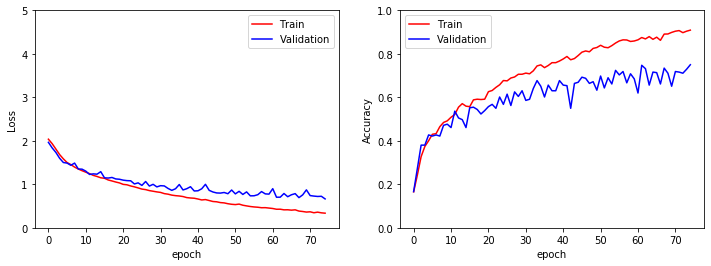

In [22]:
plot_results(res)

Instructions for updating:
Please use Model.predict, which supports generators.
Prediction shape is (465, 9)
              precision    recall  f1-score   support

         -15       0.64      0.55      0.59        71
         -30       0.65      0.66      0.66        68
         -60       0.69      0.85      0.76        59
         -90       1.00      0.33      0.50         3
           0       0.69      0.71      0.70        59
          15       0.85      0.61      0.71        64
          30       0.76      0.92      0.83        75
          60       0.87      0.92      0.89        60
          90       1.00      0.17      0.29         6

    accuracy                           0.73       465
   macro avg       0.79      0.64      0.66       465
weighted avg       0.74      0.73      0.73       465



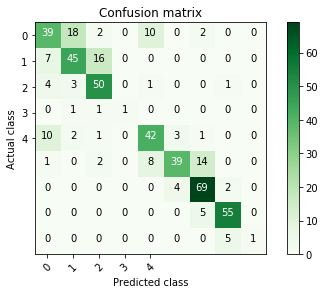

In [23]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model1.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Using Regularization 
we are using categorical_crossentropy since the output variable contains nine classes.

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy

# Input layer
input_ = Input(shape=(32, 32, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
# reg for weight matrix 1
h = Dense(64,kernel_regularizer=regularizers.l2(0.01))(x)
h = Activation('relu')(h)

# Output layer
# reg for weight matrix 2
out_ = Dense(9,kernel_regularizer=regularizers.l2(0.01))(h)
out_ = Activation('softmax')(out_)

# Define model
model_orig1 = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_orig1.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


model_orig1.summary()
# Creating a model for feature vizualization 
hidden_features = Model(inputs=input_, outputs=h)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                65600     
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 585       
_________________________________________________________________
activation_3 (Activation)    (None, 9)                 0   

In [25]:
#training the model1
res = train_model(model_orig1, num_epoch=50, verbose=1)

Training epoch 0: Loss = 3.167572259902954, Accuracy = 0.2264784872531891
Validation epoch 0: Loss = 2.7006737192471824, Accuracy = 0.3359375
Training epoch 1: Loss = 2.518580913543701, Accuracy = 0.352419376373291
Validation epoch 1: Loss = 2.2479976614316306, Accuracy = 0.4427083432674408
Training epoch 2: Loss = 2.1623611450195312, Accuracy = 0.3930107355117798
Validation epoch 2: Loss = 2.0106055786212287, Accuracy = 0.421875
Training epoch 3: Loss = 1.9621999263763428, Accuracy = 0.426075279712677
Validation epoch 3: Loss = 1.901921679576238, Accuracy = 0.4088541567325592
Training epoch 4: Loss = 1.8213438987731934, Accuracy = 0.4353494644165039
Validation epoch 4: Loss = 1.738109936316808, Accuracy = 0.4557291567325592
Training epoch 5: Loss = 1.7286760807037354, Accuracy = 0.4490591585636139
Validation epoch 5: Loss = 1.631376971801122, Accuracy = 0.4947916567325592
Training epoch 6: Loss = 1.6772680282592773, Accuracy = 0.4564516246318817
Validation epoch 6: Loss = 1.6077486375

In [26]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

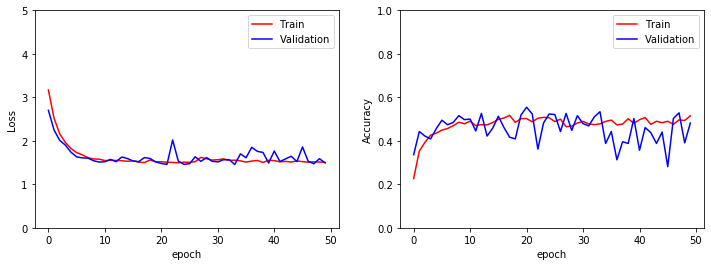

In [27]:
plot_results(res)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn = Sequential()

model_cnn.add(Conv2D(64, (5, 5), input_shape = (32,32,1)))
model_cnn.add(Activation('relu'))

model_cnn.add(Conv2D(64, (5, 5)))
model_cnn.add(Activation('relu'))

model_cnn.add(Flatten())  
model_cnn.add(Dense(128))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.3))

model_cnn.add(Dense(9))
model_cnn.add(Activation('softmax'))

## Model 3
 Using the final layer as Multi layer perceptron.

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input,BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

Model3 = Sequential()

# input
Model3.add(Input(shape=(32, 32, 3)))

# Model1.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
Model3.add(Conv2D(32, (3, 3)))
Model3.add(Activation('relu'))

# Conv Layer 2
Model3.add(Conv2D(64, (3, 3)))
Model3.add(Activation('relu'))
Model3.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
Model3.add(Flatten())
Model3.add(Dense(64))
Model3.add(Activation('relu'))
Model3.add(Dense(9))
Model3.add(Activation('softmax'))

Model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

Model3.summary()

res = train_model(Model3, num_epoch= 75, verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [30]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

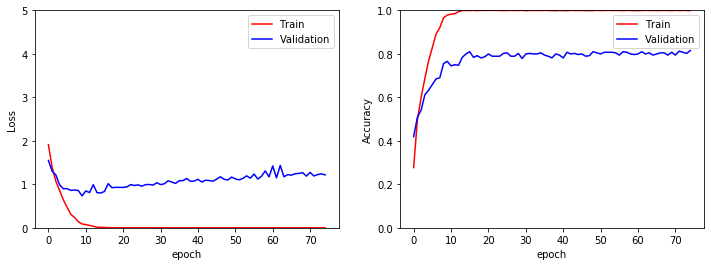

In [31]:
plot_results(res)

Prediction shape is (465, 9)
              precision    recall  f1-score   support

         -15       0.71      0.75      0.73        71
         -30       0.76      0.82      0.79        68
         -60       0.86      0.75      0.80        59
         -90       0.50      0.67      0.57         3
           0       0.80      0.80      0.80        59
          15       0.89      0.88      0.88        64
          30       0.88      0.87      0.87        75
          60       0.89      0.92      0.90        60
          90       1.00      0.50      0.67         6

    accuracy                           0.82       465
   macro avg       0.81      0.77      0.78       465
weighted avg       0.82      0.82      0.82       465



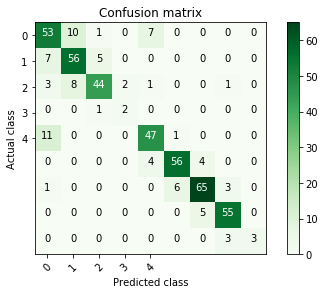

In [32]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = Model3.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Model 4
Using adam optimiser, it mitigates the saturation issue which sigmoid posses.

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model4 = Sequential()

model4.add(Conv2D(64, (5, 5), input_shape = (32,32,3)))
model4.add(Activation('relu'))

model4.add(Conv2D(64, (5, 5)))
model4.add(Activation('relu'))

model4.add(Flatten())  
model4.add(Dense(128))
model4.add(Activation('relu'))
model4.add(Dropout(0.3))

model4.add(Dense(9))
model4.add(Activation('softmax'))

adam = optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
model4.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=[categorical_accuracy])
adam = optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
model4.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=[categorical_accuracy])
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
activation_13 (Activation)   (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               4718720   
_________________________________________________________________
activation_14 (Activation)   (None, 128)              

In [34]:
#training the model4
res = train_model(model4, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.1037800312042236, Accuracy = 0.17271505296230316
Validation epoch 0: Loss = 1.8712560882170994, Accuracy = 0.2473958283662796
Training epoch 1: Loss = 1.766125202178955, Accuracy = 0.33198925852775574
Validation epoch 1: Loss = 1.4927578469117482, Accuracy = 0.4010416567325592
Training epoch 2: Loss = 1.4198946952819824, Accuracy = 0.44758063554763794
Validation epoch 2: Loss = 1.2549592753251393, Accuracy = 0.4713541567325592
Training epoch 3: Loss = 1.1725330352783203, Accuracy = 0.5413978099822998
Validation epoch 3: Loss = 1.0602689161896706, Accuracy = 0.5729166865348816
Training epoch 4: Loss = 0.9627450108528137, Accuracy = 0.6126344203948975
Validation epoch 4: Loss = 0.9103072732686996, Accuracy = 0.6380208134651184
Training epoch 5: Loss = 0.792731523513794, Accuracy = 0.6919354796409607
Validation epoch 5: Loss = 0.7825264583031336, Accuracy = 0.6953125
Training epoch 6: Loss = 0.663305401802063, Accuracy = 0.7387096285820007
Validation epoch 6: Lo

In [35]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

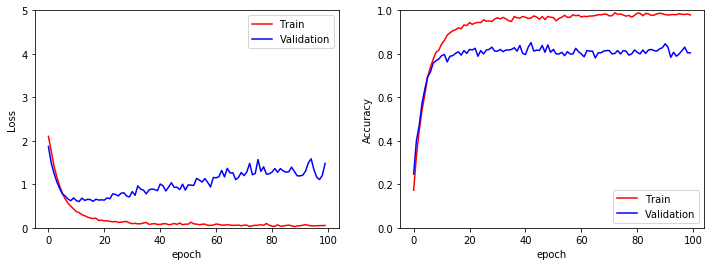

In [36]:
plot_results(res)

Prediction shape is (465, 9)
              precision    recall  f1-score   support

         -15       0.69      0.68      0.68        71
         -30       0.79      0.72      0.75        68
         -60       0.83      0.90      0.86        59
         -90       1.00      0.33      0.50         3
           0       0.81      0.78      0.79        59
          15       0.86      0.94      0.90        64
          30       0.87      0.91      0.89        75
          60       0.92      0.90      0.91        60
          90       0.75      0.50      0.60         6

    accuracy                           0.82       465
   macro avg       0.83      0.74      0.76       465
weighted avg       0.82      0.82      0.82       465



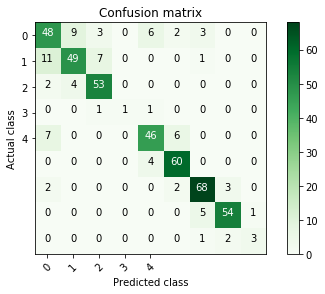

In [37]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model4.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Model 5 - with decay element in adam optimiser

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model5 = Sequential()

model5.add(Conv2D(32, (3, 3), input_shape = (32,32,3)))
model5.add(Activation('relu'))

model5.add(Conv2D(64, (3, 3)))
model5.add(Activation('relu'))

model5.add(Flatten())  
model5.add(Dense(128))
model5.add(Activation('relu'))
model5.add(Dropout(0.3))

model5.add(Dense(9))
model5.add(Activation('softmax'))

adam = optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    decay=5e-05,
    amsgrad=False)
model5.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=[categorical_accuracy])
model5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_16 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_17 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               6422656   
_________________________________________________________________
activation_18 (Activation)   (None, 128)              

In [39]:
#training the model4
res = train_model(model5, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.07490873336792, Accuracy = 0.22782258689403534
Validation epoch 0: Loss = 1.6578158289194107, Accuracy = 0.3619791567325592
Training epoch 1: Loss = 1.4915962219238281, Accuracy = 0.4440860152244568
Validation epoch 1: Loss = 1.2851315140724182, Accuracy = 0.4921875
Training epoch 2: Loss = 1.1115726232528687, Accuracy = 0.5802419781684875
Validation epoch 2: Loss = 1.0782196422417958, Accuracy = 0.5364583134651184
Training epoch 3: Loss = 0.7751924395561218, Accuracy = 0.7072581052780151
Validation epoch 3: Loss = 0.8874346166849136, Accuracy = 0.6067708134651184
Training epoch 4: Loss = 0.5479635000228882, Accuracy = 0.8040322661399841
Validation epoch 4: Loss = 0.6932669555147489, Accuracy = 0.7239583134651184
Training epoch 5: Loss = 0.4237685203552246, Accuracy = 0.8442203998565674
Validation epoch 5: Loss = 0.7033195731540521, Accuracy = 0.6927083134651184
Training epoch 6: Loss = 0.28226348757743835, Accuracy = 0.9043010473251343
Validation epoch 6: Lo

In [40]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

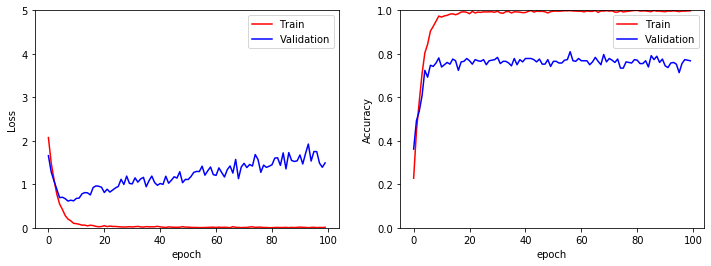

In [41]:
plot_results(res)

Prediction shape is (465, 9)
              precision    recall  f1-score   support

         -15       0.76      0.55      0.64        71
         -30       0.71      0.87      0.78        68
         -60       0.89      0.80      0.84        59
         -90       1.00      0.33      0.50         3
           0       0.69      0.81      0.74        59
          15       0.80      0.75      0.77        64
          30       0.81      0.92      0.86        75
          60       0.90      0.90      0.90        60
          90       1.00      0.33      0.50         6

    accuracy                           0.79       465
   macro avg       0.84      0.70      0.73       465
weighted avg       0.80      0.79      0.78       465



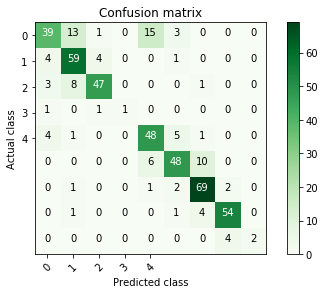

In [42]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model5.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


# Model 6 - Adding more layers

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model6 = Sequential()

model6.add(Conv2D(64, (3, 3), input_shape = (32,32,3)))
model6.add(Activation('relu'))

model6.add(Conv2D(64, (3, 3)))
model6.add(Activation('relu'))

model6.add(Conv2D(64, (3, 3)))
model6.add(Activation('relu'))

model6.add(Flatten())  
model6.add(Dense(128))
model6.add(Activation('relu'))
model6.add(Dropout(0.3))

model6.add(Dense(9))
model6.add(Activation('softmax'))

adam = optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    decay=5e-05,
    amsgrad=False)
model6.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=[categorical_accuracy])
model6.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
activation_20 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_21 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
activation_22 (Activation)   (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 43264)            

In [44]:
#training the model1
res = train_model(model6, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.0396342277526855, Accuracy = 0.1989247351884842
Validation epoch 0: Loss = 1.8534122854471207, Accuracy = 0.265625
Training epoch 1: Loss = 1.6645127534866333, Accuracy = 0.3685483932495117
Validation epoch 1: Loss = 1.4030878245830536, Accuracy = 0.4479166567325592
Training epoch 2: Loss = 1.2694439888000488, Accuracy = 0.51572585105896
Validation epoch 2: Loss = 1.137418565650781, Accuracy = 0.515625
Training epoch 3: Loss = 0.9489979147911072, Accuracy = 0.6290322542190552
Validation epoch 3: Loss = 0.9741390434404215, Accuracy = 0.6276041865348816
Training epoch 4: Loss = 0.6987224221229553, Accuracy = 0.7224462628364563
Validation epoch 4: Loss = 0.7972454478343328, Accuracy = 0.6432291865348816
Training epoch 5: Loss = 0.5005549788475037, Accuracy = 0.807930052280426
Validation epoch 5: Loss = 0.7890660439928373, Accuracy = 0.6770833134651184
Training epoch 6: Loss = 0.3805680572986603, Accuracy = 0.859005331993103
Validation epoch 6: Loss = 0.787432470

In [45]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])


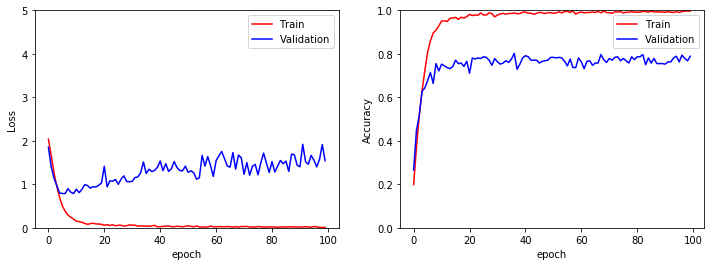

In [46]:
plot_results(res)

Prediction shape is (465, 9)
              precision    recall  f1-score   support

         -15       0.62      0.70      0.66        71
         -30       0.71      0.69      0.70        68
         -60       0.79      0.76      0.78        59
         -90       0.50      0.33      0.40         3
           0       0.80      0.75      0.77        59
          15       0.81      0.89      0.85        64
          30       0.94      0.89      0.92        75
          60       0.92      0.93      0.93        60
          90       1.00      0.33      0.50         6

    accuracy                           0.79       465
   macro avg       0.79      0.70      0.72       465
weighted avg       0.80      0.79      0.79       465



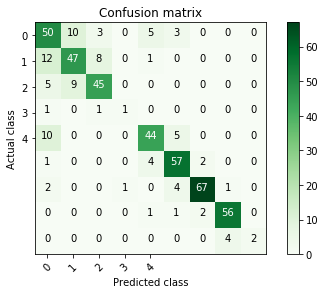

In [47]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model6.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Model 7 - using adam optimiser and Dropouts

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model7 = Sequential()

# input
model7.add(Input(shape=(32, 32, 3)))
model7.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# Conv Layer 1
model7.add(Conv2D(64, (3, 3),))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 (no pooling)
model7.add(Conv2D(64, (3, 3),))
model7.add(Activation('relu'))

# Conv Layer 3
model7.add(Conv2D(128, (3, 3)))
model7.add(Activation('relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model7.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model7.add(Dense(128))
model7.add(Activation('relu'))
model7.add(Dropout(0.5))
model7.add(Dense(9))
model7.add(Activation('softmax'))

adam = optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
model7.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
# model_cnn.save_weights('model.h5')

model7.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
activation_25 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
activation_26 (Activation)   (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 128)      

In [49]:
#training the model1
res = train_model(model7, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.083714723587036, Accuracy = 0.14516128599643707
Validation epoch 0: Loss = 1.975896954536438, Accuracy = 0.2838541567325592
Training epoch 1: Loss = 1.8721438646316528, Accuracy = 0.2595430314540863
Validation epoch 1: Loss = 1.6170254200696945, Accuracy = 0.40625
Training epoch 2: Loss = 1.5663648843765259, Accuracy = 0.37190860509872437
Validation epoch 2: Loss = 1.426654686530431, Accuracy = 0.421875
Training epoch 3: Loss = 1.3521790504455566, Accuracy = 0.46626344323158264
Validation epoch 3: Loss = 1.21743197987477, Accuracy = 0.4765625
Training epoch 4: Loss = 1.1995301246643066, Accuracy = 0.5194892287254333
Validation epoch 4: Loss = 1.1103559161225955, Accuracy = 0.5703125
Training epoch 5: Loss = 1.106881022453308, Accuracy = 0.5474461913108826
Validation epoch 5: Loss = 1.0085219765702884, Accuracy = 0.5911458134651184
Training epoch 6: Loss = 1.0002505779266357, Accuracy = 0.58588707447052
Validation epoch 6: Loss = 0.9038808072606722, Accuracy =

In [50]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])


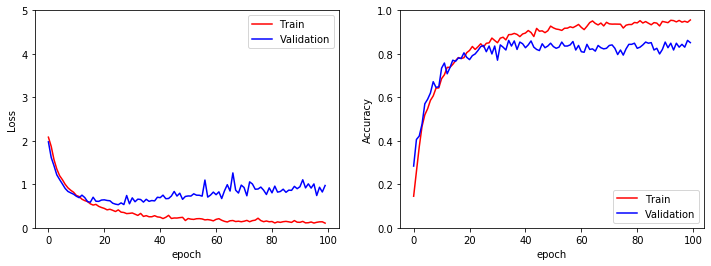

In [51]:
plot_results(res)

Prediction shape is (465, 9)
              precision    recall  f1-score   support

         -15       0.80      0.68      0.73        71
         -30       0.73      0.90      0.81        68
         -60       0.89      0.86      0.88        59
         -90       1.00      0.33      0.50         3
           0       0.83      0.81      0.82        59
          15       0.88      0.92      0.90        64
          30       0.99      0.92      0.95        75
          60       0.91      0.98      0.94        60
          90       0.75      0.50      0.60         6

    accuracy                           0.86       465
   macro avg       0.86      0.77      0.79       465
weighted avg       0.86      0.86      0.86       465



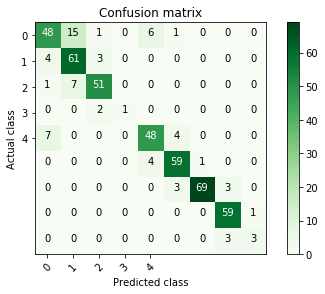

In [52]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model7.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Model 8 
Using Drop outs reduces the complexity. 

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model8 = Sequential()

# input
model8.add(Input(shape=(32, 32, 3)))
model8.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# Conv Layer 1
model8.add(Conv2D(64, (3, 3),))
model8.add(Activation('relu'))
model8.add(Dropout(0.5))
model8.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 (no pooling)
model8.add(Conv2D(64, (3, 3),))
model8.add(Activation('relu'))
model8.add(Dropout(0.5))

# Conv Layer 3
model8.add(Conv2D(128, (3, 3)))
model8.add(Activation('relu'))
model8.add(Dropout(0.5))
model8.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model8.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model8.add(Dense(128))
model8.add(Activation('relu'))
model8.add(Dropout(0.5))
model8.add(Dense(9))
model8.add(Activation('softmax'))

adam = optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
model8.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
# model_cnn.save_weights('model.h5')

model8.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
activation_30 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
activation_31 (Activation)   (None, 13, 13, 64)       

In [54]:
#training the model1
res = train_model(model8, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.102308750152588, Accuracy = 0.14919355511665344
Validation epoch 0: Loss = 2.1141232748826346, Accuracy = 0.140625
Training epoch 1: Loss = 1.9908688068389893, Accuracy = 0.20510753989219666
Validation epoch 1: Loss = 2.018164962530136, Accuracy = 0.3958333432674408
Training epoch 2: Loss = 1.7916656732559204, Accuracy = 0.29932793974876404
Validation epoch 2: Loss = 1.8588166882594426, Accuracy = 0.3932291567325592
Training epoch 3: Loss = 1.6285117864608765, Accuracy = 0.3522849678993225
Validation epoch 3: Loss = 1.7345449030399323, Accuracy = 0.4348958432674408
Training epoch 4: Loss = 1.5310347080230713, Accuracy = 0.3774193525314331
Validation epoch 4: Loss = 1.6925253172715504, Accuracy = 0.4583333432674408
Training epoch 5: Loss = 1.4049147367477417, Accuracy = 0.4419354796409607
Validation epoch 5: Loss = 1.5243522673845291, Accuracy = 0.4713541567325592
Training epoch 6: Loss = 1.3515591621398926, Accuracy = 0.4676075279712677
Validation epoch 6: Lo

In [55]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])


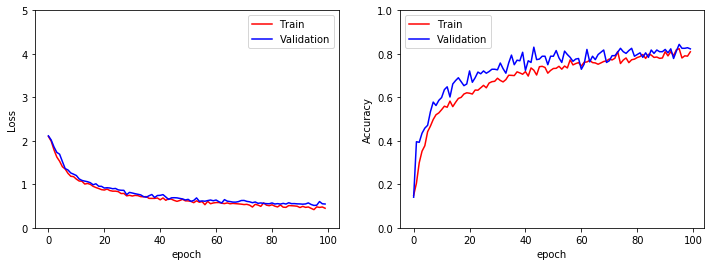

In [56]:
plot_results(res)

Prediction shape is (465, 9)
              precision    recall  f1-score   support

         -15       0.88      0.69      0.77        71
         -30       0.68      0.93      0.79        68
         -60       0.95      0.69      0.80        59
         -90       1.00      0.67      0.80         3
           0       0.75      0.86      0.80        59
          15       0.90      0.89      0.90        64
          30       0.96      0.95      0.95        75
          60       0.94      0.98      0.96        60
          90       0.75      0.50      0.60         6

    accuracy                           0.85       465
   macro avg       0.87      0.80      0.82       465
weighted avg       0.87      0.85      0.85       465



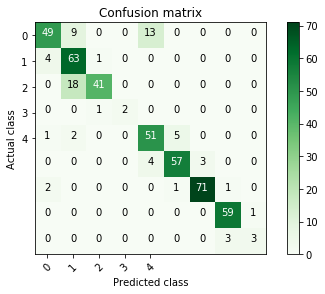

In [57]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model8.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Prediction

In [58]:
df = pd.read_csv('test_data.csv')
headpose_data
df.head()

,filename,person_id,series
0,face_33.jpg,2,1
1,face_2148.jpg,2,2
2,face_2119.jpg,2,1
3,face_1262.jpg,2,1
4,face_516.jpg,2,2


In [59]:
dfv2 = pd.merge(df,headpose_data, on='filename')

In [60]:
dfv2.head()

,filename,person_id,series,image_path
0,face_33.jpg,2,1,modified_data/face_33.jpg
1,face_2148.jpg,2,2,modified_data/face_2148.jpg
2,face_2119.jpg,2,1,modified_data/face_2119.jpg
3,face_1262.jpg,2,1,modified_data/face_1262.jpg
4,face_516.jpg,2,2,modified_data/face_516.jpg


In [61]:
submission_df = dfv2[['filename','image_path']]

In [62]:
new_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

new_generator = new_datagen.flow_from_dataframe(
    dataframe=submission_df,
    directory='./modified_data', 
    x_col="filename", 
    y_col="image_path", 
    target_size=(32, 32), 
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')


Found 465 validated image filenames belonging to 465 classes.


In [63]:
y_pred = model8.predict_generator(new_generator,verbose=1)
print("Test dataset shape", y_pred.shape)

Y_pred_labels =[]
for i in range(0,len(y_pred[:,0])):
    Y_pred_labels.append(np.argmax(predictions[i]))

Y_pred_labels = np.asarray(Y_pred_labels)

30/30 [==============================] - 1s 21ms/step
Test dataset shape (465, 9)


In [64]:
for image, x in enumerate(Y_pred_labels):
    if x == 0:
        predictedLabels[image] = -15
    elif x == 1:
        predictedLabels[image] = -30
    elif x == 2:
        predictedLabels[image] = -60
    elif x == 3:
        predictedLabels[image] = -90
    elif x == 4:
        predictedLabels[image] = 0
    elif x == 5:
        predictedLabels[image] = 15
    elif x == 6:
        predictedLabels[image] = 30
    elif x == 7:
        predictedLabels[image] = 60
    else:
        predictedLabels[image] = 90

In [65]:
import pandas as pd
df = pd.DataFrame(predictedLabels, columns=["tilt"])
result = pd.concat([submission_df['filename'],df], axis=1, sort=False)

In [66]:
result.head()

,filename,tilt
0,face_33.jpg,30
1,face_2148.jpg,-30
2,face_2119.jpg,-15
3,face_1262.jpg,30
4,face_516.jpg,0


In [67]:
result.to_csv('s3763905_tilt_predictions.csv', index=False)